In [29]:
import torch
import gpytorch
import random
from gpytorch.likelihoods import GaussianLikelihood, DirichletClassificationLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from alse.eci import ExpectedCoverageImprovement
from alse.gp_model import DirichletGPModel

In [30]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

In [31]:
import pandas
real_data = pandas.read_excel('4340_2.5.xlsx')

power = torch.tensor(real_data.loc[:,"P (W)"])
velocity = torch.tensor(real_data.loc[:,"V (mm/min)"])
width = torch.tensor(real_data.loc[:,"widths avg (mm)"]).unsqueeze(-1)
pow_cap = torch.tensor(real_data.loc[:,"powder capt %"]/100).unsqueeze(-1)
height = torch.tensor(real_data.loc[:,"heights avg (mm)"])
adhere = (torch.ones(height.shape).bool() & height.bool()).long()
# adhere = torch.stack((adhere, adhere), -1)
X = torch.stack((power, velocity), -1)

In [32]:
X=(X-200)/2800

In [33]:
def get_and_fit_gp(X, Y):
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-9, 1e-6))  # Noise-free
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

In [34]:
X.shape

torch.Size([40, 2])

In [35]:
adhere

tensor([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
gp_model_width = get_and_fit_gp(X, width)
gp_model_pow_cap = get_and_fit_gp(X, pow_cap)


adhere_likelihood = DirichletClassificationLikelihood(adhere, learn_additional_noise=True)
gp_model_adhere = DirichletGPModel(X, adhere_likelihood.transformed_targets, adhere_likelihood, num_classes=adhere_likelihood.num_classes)

In [37]:
gp_model_adhere.train()
adhere_likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(gp_model_adhere.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(adhere_likelihood, gp_model_adhere)

for i in range(100):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp_model_adhere(X)
    # Calc loss and backprop gradients
    loss = -mll(output, adhere_likelihood.transformed_targets).sum()
    loss.backward()
    optimizer.step()

In [38]:
N1, N2 = 150, 150
Xplt, Yplt = torch.meshgrid(
    torch.linspace(0, 3000, N1, **tkwargs), torch.linspace(0, 3000, N2, **tkwargs),
    indexing='xy',
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)

In [39]:
predicted_width = gp_model_width(xplt/3000).loc.detach().reshape(N1,N2)
predicted_pow_cap = gp_model_pow_cap(xplt/3000).loc.detach().reshape(N1,N2)

In [40]:
test_point = torch.tensor([[1500,  2600]])
gp_model_width(test_point.float()).loc.detach()

tensor([1.4835])

In [41]:
gp_model_width.covar_module.base_kernel.lengthscale

tensor([[0.6803, 0.4432]], grad_fn=<SoftplusBackward0>)

In [42]:
gp_model_adhere.eval()
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = gp_model_adhere(xplt/3000)
    pred_means = test_dist.loc


pred_samples = test_dist.sample(torch.Size((256,))).exp()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
# probabilities[0] = probabilities[0]*(probabilities[0].max()-probabilities[0].min())
# probabilities[1] = probabilities[1]/probabilities[1].max()

predicted_adhere = probabilities.max(0)[1].reshape(N1,N2)


In [43]:
X=X*2800+200

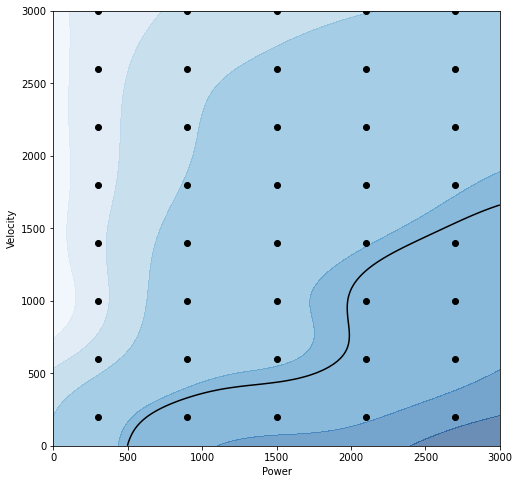

In [44]:
plt.subplots(figsize=(8, 8))
plt.contourf(Xplt, Yplt, predicted_width, cmap="Blues", alpha=0.6)
plt.contour(Xplt, Yplt, predicted_width, [2.5], colors="k")
plt.xlabel("Power")
plt.ylabel("Velocity")
plt.plot(X[:,0], X[:,1], "ko")


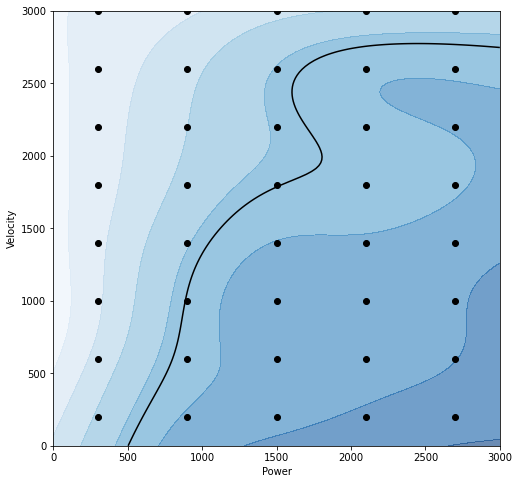

In [45]:
plt.subplots(figsize=(8, 8))
plt.contourf(Xplt, Yplt, predicted_pow_cap, cmap="Blues", alpha=0.6)
plt.contour(Xplt, Yplt, predicted_pow_cap, [0.5], colors="k")
plt.xlabel("Power")
plt.ylabel("Velocity")
plt.plot(X[:,0], X[:,1], "ko")

In [46]:
(pred_means[1] > pred_means[0]).shape

torch.Size([22500])

In [47]:
(pred_means[1] > pred_means[0]).sum()

tensor(22109)

In [48]:
pred_means[1].min()

tensor(-0.5443)

In [49]:
pred_means[0].max()

tensor(-0.0310)

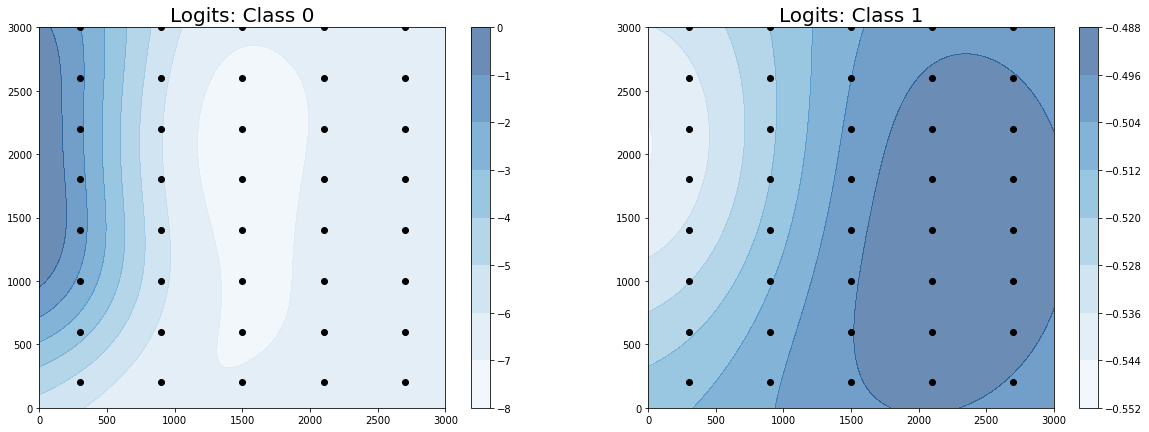

In [50]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

for i in range(2):
    im = ax[i].contourf(
        Xplt.numpy(), Yplt.numpy(), pred_means[i].numpy().reshape(N1,N2),
    cmap="Blues", alpha=0.6)
    fig.colorbar(im, ax=ax[i])
    ax[i].plot(X[:,0].numpy(), X[:,1].numpy(), "ko")
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

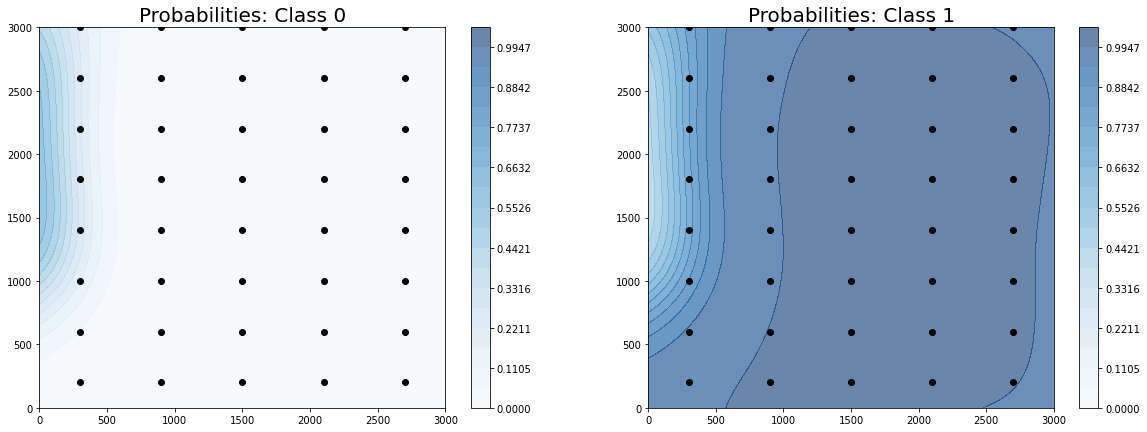

In [51]:
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

levels = np.linspace(0, 1.05, 20)
for i in range(2):
    im = ax[i].contourf(
        Xplt.numpy(), Yplt.numpy(), probabilities[i].numpy().reshape(N1,N2), levels=levels,
    cmap="Blues", alpha=0.6)
    fig.colorbar(im, ax=ax[i])
    ax[i].plot(X[:,0].numpy(), X[:,1].numpy(), "ko")
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

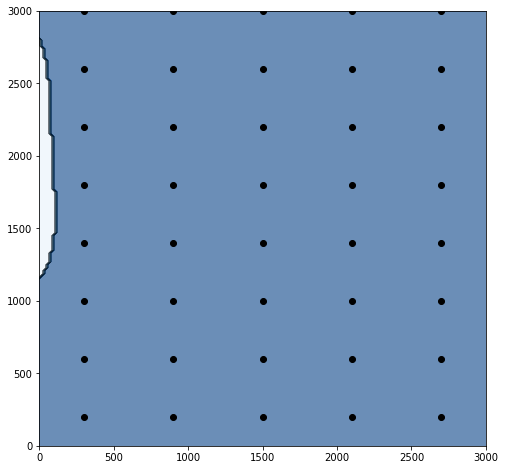

In [52]:
plt.subplots(figsize=(8, 8))
plt.contourf(Xplt.cpu(), Yplt.cpu(), predicted_adhere.cpu(), cmap="Blues", alpha=0.6)
plt.contour(Xplt.cpu(), Yplt.cpu(), predicted_adhere.cpu(), colors="k", linewidths=0.3)
plt.plot(X[:,0].numpy(), X[:,1].numpy(), "ko")

In [53]:
            #   width > 2.5  powder capture > 50%    place holder
constraints = [("gt", 2.5),    ("gt", 0.5),          ("gt", 0.1)]
punchout_radius = 0.001
bounds = torch.tensor([[200, 200], [3000, 3000]], **tkwargs)
lb, ub = bounds


In [54]:

# We don't have to normalize X since the domain is [0, 1]^2. Make sure to
# appropriately adjust the punchout radius if the domain is normalized.

model_list_gp = ModelListGP(gp_model_width, gp_model_pow_cap, gp_model_adhere)

eci = ExpectedCoverageImprovement(
    model=model_list_gp,
    constraints=constraints,
    punchout_radius=punchout_radius,
    bounds=bounds,
    num_samples=512
)

x_next, _ = optimize_acqf(
    acq_function=eci,
    bounds=bounds,
    q=1,
    num_restarts=10,
    raw_samples=512
)
new_power = round(x_next[0][0].item(), 2)
new_velocity = round(x_next[0][1].item(), 2)
print(f"New X: Power: {new_power}W, Velocity: {new_velocity}mm/min")

C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\gpytorch\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


New X: Power: 767.39W, Velocity: 2397.79mm/min


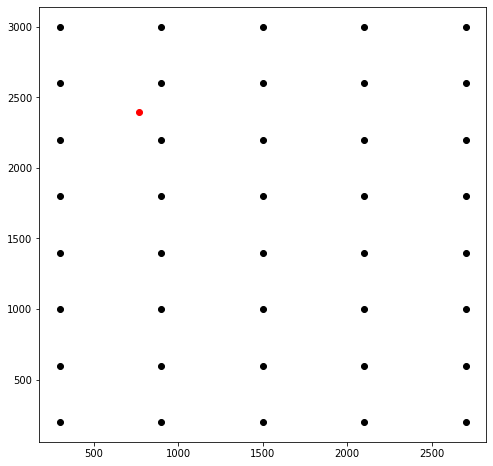

In [55]:
plt.subplots(figsize=(8, 8))
plt.plot(X[:,0], X[:,1], "ko")
plt.plot(x_next[0][0], x_next[0][1], "ro")


In [56]:
est_width = predicted_width > 2.5
est_pow_cap = predicted_pow_cap > 0.5
est_adhere = predicted_adhere

reference = (est_width & est_pow_cap & est_adhere)

In [57]:
est_width.sum()

tensor(5091)

In [58]:
est_pow_cap.sum()

tensor(12555)

In [59]:
est_adhere.sum()

tensor(22150)

In [61]:
reference.sum()

tensor(5088)

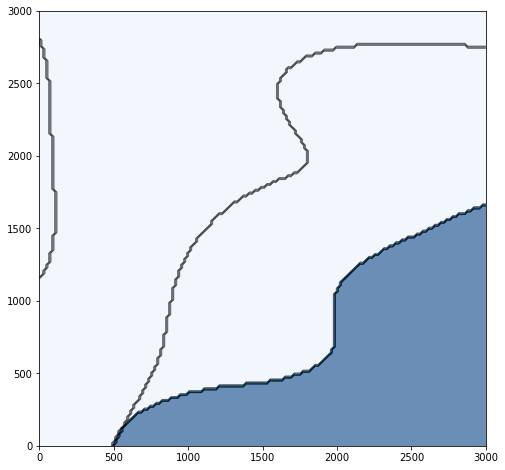

In [74]:
plt.subplots(figsize=(8, 8))
plt.contour(Xplt.cpu(), Yplt.cpu(), est_width.cpu(), colors="k", linewidths=0.3)
plt.contour(Xplt.cpu(), Yplt.cpu(), est_pow_cap.cpu(), colors="k", linewidths=0.3)
plt.contour(Xplt.cpu(), Yplt.cpu(), est_adhere.cpu(), colors="k", linewidths=0.3)
plt.contourf(Xplt.cpu(), Yplt.cpu(), reference.cpu(), cmap="Blues", alpha=0.6)